In [1]:
import numpy as np

import matplotlib.pyplot as plt
import importlib

import findatree.io as io
import findatree.visualize as visual
import findatree.segmentation as segment
import findatree.object_properties as obj_props

plt.style.use(r"C:\Repos\findatree\own.mplstyle")

### Define paths to rasters

In [5]:
importlib.reload(io)

dir_names=[]
dir_names.extend([r'C:\Data\lwf\DSM_2021'])
dir_names.extend([r'C:\Data\lwf\DTM'])
dir_names.extend([r'C:\Data\lwf\Orthophotos_2021'])

paths, params_paths = io.find_paths_in_dirs(dir_names, tnr_number=11878)
# io.print_raster_info(paths)

1 dsms found in given directories, OK.
  -> Returning dsm: Tnr_11878_D-20210713_DSM.tif
1 dtms found in given directories, OK.
  -> Returning dtm: tnr_11878_dtm.tif
1 orthos found in given directories, OK.
  -> Returning ortho: Tnr_11878_D-20210713_Ortho.tif
-----------
Parameters:
  tnr                           : 11878
  path_dsm                      : C:\Data\lwf\DSM_2021\Tnr_11878_D-20210713_DSM.tif
  path_dtm                      : C:\Data\lwf\DTM\tnr_11878_dtm.tif
  path_ortho                    : C:\Data\lwf\Orthophotos_2021\Tnr_11878_D-20210713_Ortho.tif


### Reproject all rasters to same area & resolution -> Primary channels

In [23]:
importlib.reload(io)

# Set final pixel resolution of all rasters
px_width = 0.2

# Reproject all rasters
cs_prim, params_cs_prim = io.reproject_all_intersect(paths, px_width=px_width)

-----------
Parameters:
  crs                           : EPSG:25832
  affine                        : [[ 2.00000000e-01  0.00000000e+00  6.58459047e+05]
 [ 0.00000000e+00 -2.00000000e-01  5.45850800e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
  px_width                      : 0.2
  shape                         : (840, 804)
  bound_left                    : 658459.0469932929
  bound_bottom                  : 5458339.999947806
  bound_right                   : 658619.992780963
  bound_top                     : 5458507.999947806


### Normalize primary channels and compute secondary channels -> Secondary channels

In [24]:
importlib.reload(io)

downscale = 0
cs, params_cs = io.channels_primary_to_secondary(cs_prim, params_cs_prim, downscale=downscale)

-----------
Parameters:
  blue_wavelength               : 450
  green_wavelength              : 560
  red_wavelength                : 650
  re_wavelength                 : 730
  nir_wavelength                : 840
  downscale                     : 0
  px_width                      : 0.2
  shape                         : (840, 804)


### Segmentation -> Objects
#### (1) Segmentation
1. Local gaussian thresholding -> mask
2. Marker based watershed with markers generated by local peaks in distance transformation of mask

In [25]:
importlib.reload(segment)

params_segment = {
    # 'thresh_downscale':0,
    # 'water_downscale':1,
}

cs_segment, params_segment = segment.main(
    cs,
    params_cs,
    params_segment,
)

    ... [io.channels_primary_to_secondary()] already secondary channels!
    ... [io.channels_primary_to_secondary()] already secondary channels!
    ... [segmentation.local_thresholding()] Gaussian thresholding kernel width: 30.0 [m] = 75 [px]
    ... [segmentation.watershed_by_peaks_in_disttrafo()] Removing holes of area: 0.00 [m**2] = 0 [px]
    ... [segmentation.watershed_by_peaks_in_disttrafo()] Peaks in distance transform separated by minimum distance: 1.2 [m] = 5 [px]
-----------
Parameters:
  thresh_global_chm             : 3
  thresh_global_ndvi            : 0.4
  thresh_channel                : l
  thresh_downscale              : 1
  thresh_blur                   : False
  thresh_width                  : 30
  water_channel                 : l
  water_downscale               : 0
  water_peak_dist               : 1.2
  water_area_thresh             : 0.0
  water_label_min_size          : 5
  thresh_shape                  : (420, 402)
  thresh_px_width               : 0.4
  wate

#### (2) Plot segmentation results

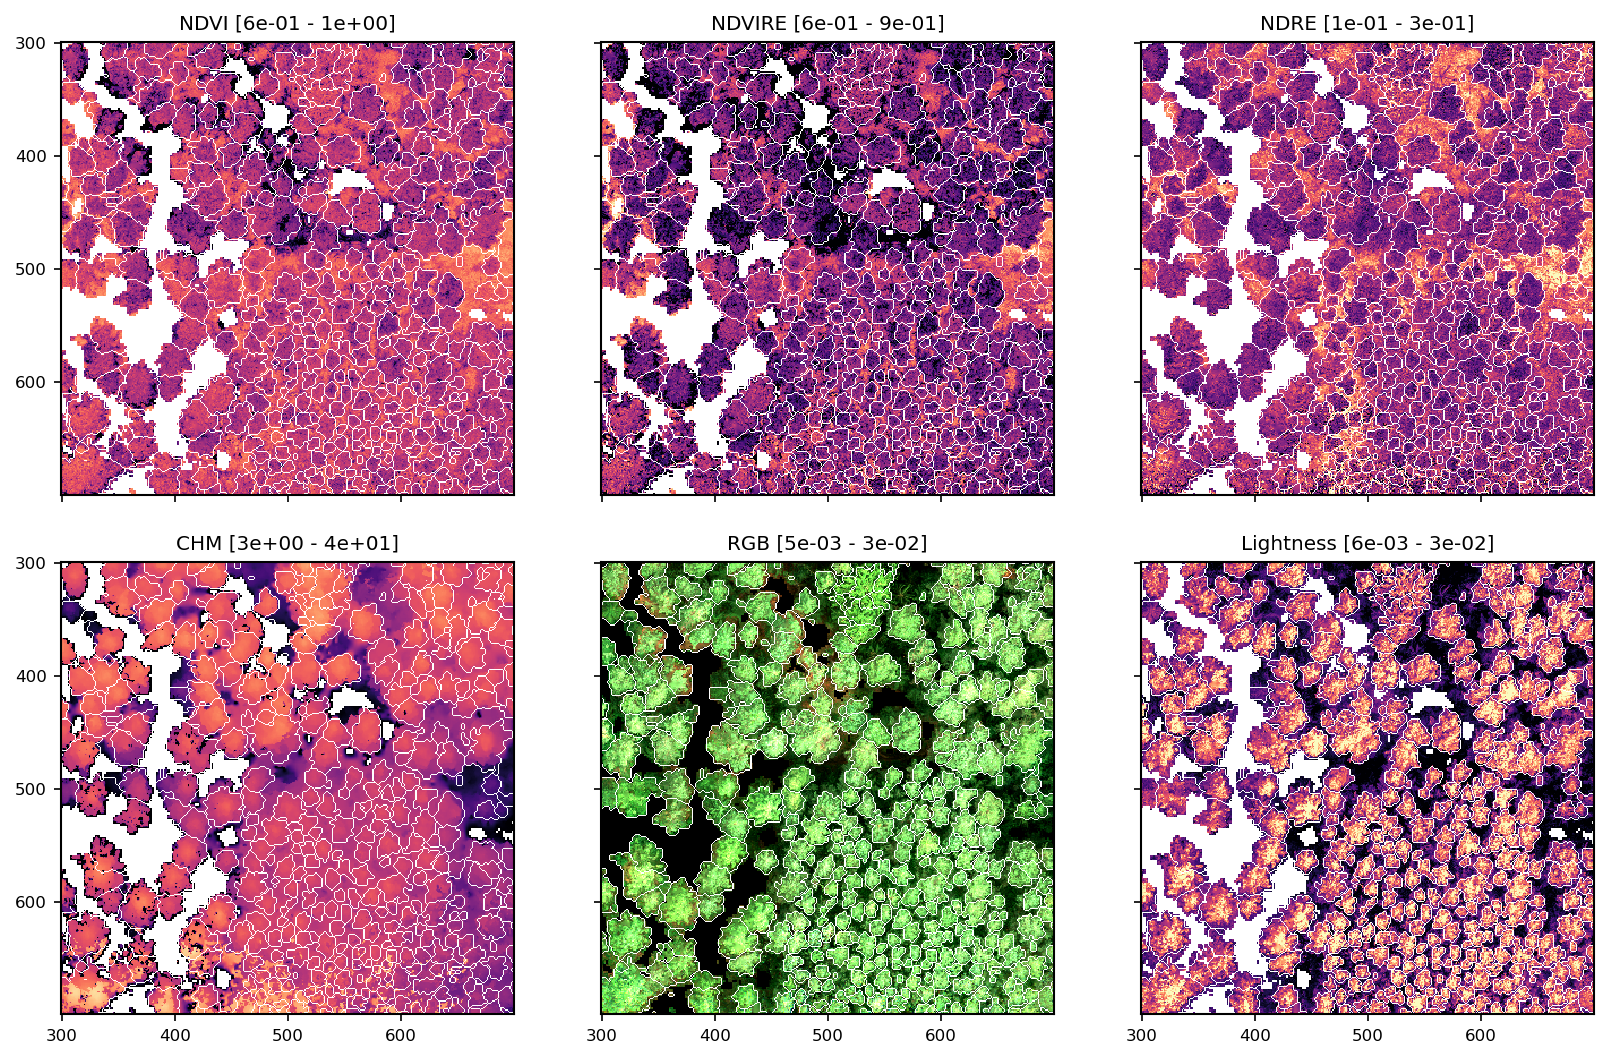

In [27]:
importlib.reload(visual)

channels = [
    cs['ndvi'], cs['ndvire'], cs['ndre'], 
    cs['chm'], cs['RGB'], cs['l'],
]
channels_names = [
    'NDVI', 'NDVIRE','NDRE',  
    'CHM', 'RGB', 'Lightness',
]
contrasts = [
    (0.6, 1), (0.6,0.9), (0.15,0.35), 
    (3, 40), None, None,
]

# ROI
width = 200
x_center = 500
y_center = 500
xylim = [(x_center, width), (y_center, width)]

f, axs = visual.show_channels(
    channels,
    xylim=xylim,
    mask=cs_segment['mask_global'],
    bounds=cs_segment['bounds'],
    contrasts=contrasts,
    channel_names=channels_names,
    zoom=1.2,
    n_cols_rows=(3,2),
)

### Object properties
#### (1) Extract object properties

In [28]:
importlib.reload(obj_props)
props, names = obj_props.labels_to_props_all(cs_segment['labels'], cs, params_cs, include_labels=None)

100%|██████████| 1047/1047 [01:02<00:00, 16.84it/s]


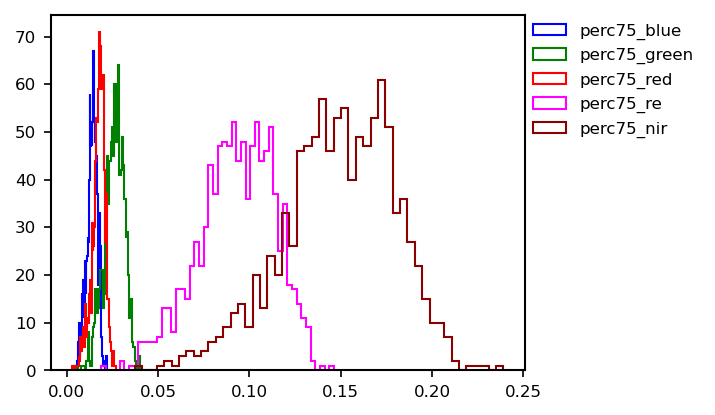

In [92]:
# print(names)

xlim = [5e-3, 1]

# Filter
name = 'perc75_chm'
positives = props[:, names.index(name)]
positives = positives > 5

select = [
    'perc75_blue',
    'perc75_green',
    'perc75_red',
    'perc75_re',
    'perc75_nir',
    ]

# select = [
#     'mean_upperl_blue',
#     'mean_upperl_green',
#     'mean_upperl_red',
#     'mean_upperl_re',
#     'mean_upperl_nir',
#     ]

# bins = np.linspace(0.5,1,70)
bins= 50


f, ax = plt.subplots(figsize=[4,3])
for name in select:
    _ = ax.hist(
        props[:, names.index(name)][positives],
        bins=bins,
        histtype='step',
        label=name,
        )

_ = ax.legend(loc='upper left',bbox_to_anchor=(1,1))
# ax.set_xlim(xlim)
# ax.set_xscale('log')

Text(0, 0.5, 'perc75_chm')

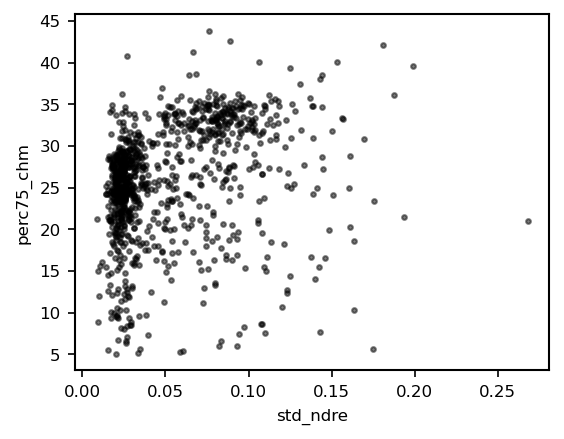

In [109]:
# print(names)

# Filter
name = 'perc75_chm'
positives = props[:, names.index(name)]
positives = positives > 5

# Variables
name1 = 'std_ndre'
feature1 = props[:, names.index(name1)]

name2 = 'perc75_chm'
feature2 = props[:, names.index(name2)]

name3 = 'perc75_s'
feature3 = props[:, names.index(name3)]

x = feature1[positives]
y = feature2[positives]
z = feature3[positives]

f, ax = plt.subplots(figsize=[4,3])
_ = ax.scatter(
    x,
    y,
    # c=z,
    color='k',
    s=5,
    alpha=0.5,
    )

ax.set_xlabel(name1)
ax.set_ylabel(name2)